In [1]:
import os
from pathlib import Path
import librosa   #for audio processing
import itertools
import pandas as pd
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")
import os,sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from clean import Clean
from eda import EDA

In [2]:
cleaning_audios = Clean()

2022-05-31 16:37:04,803:logger:Successfully initialized clean class


In [3]:
swahilis = cleaning_audios.load_audios('swahili','train',start=0,stop=5)
amharics = cleaning_audios.load_audios('amharics','train',start=0,stop=5)

2022-05-31 16:37:07,998:logger:successfully loaded ../data/swahili_train_wav/SWH-15-20110224/SWH-15-20110224_16k-emission_swahili_15h00_-_16h00_tu_20110224_part12.wav
2022-05-31 16:37:08,332:logger:successfully loaded ../data/swahili_train_wav/SWH-15-20110224/SWH-15-20110224_16k-emission_swahili_15h00_-_16h00_tu_20110224_part131.wav
2022-05-31 16:37:08,554:logger:successfully loaded ../data/swahili_train_wav/SWH-15-20110224/SWH-15-20110224_16k-emission_swahili_15h00_-_16h00_tu_20110224_part474.wav
2022-05-31 16:37:09,033:logger:successfully loaded ../data/swahili_train_wav/SWH-15-20110224/SWH-15-20110224_16k-emission_swahili_15h00_-_16h00_tu_20110224_part10.wav
2022-05-31 16:37:09,410:logger:successfully loaded ../data/swahili_train_wav/SWH-15-20110224/SWH-15-20110224_16k-emission_swahili_15h00_-_16h00_tu_20110224_part13.wav
2022-05-31 16:37:09,411:logger:The audio files duration is successfully computed
2022-05-31 16:37:09,413:logger:The audio files duration is successfully computed
2


This returns an audio time series as a numpy array with a default sampling rate(sr) of 22KHZ mono. We can change this behavior by resampling at 44.1KHz.

In [4]:
swahilis

[(array([ 0.03245375,  0.03846586,  0.0385337 , ..., -0.07476594,
         -0.05082636, -0.02326697], dtype=float32),
  44100,
  3.26),
 (array([-0.02488699, -0.03716682, -0.04580902, ...,  0.1096026 ,
          0.07886446,  0.03810541], dtype=float32),
  44100,
  3.46),
 (array([-0.00017227, -0.00018666, -0.00015308, ...,  0.07018407,
          0.03893354,  0.        ], dtype=float32),
  44100,
  2.559954648526077),
 (array([0.0269126 , 0.03767747, 0.04547471, ..., 0.10734788, 0.07342707,
         0.03271665], dtype=float32),
  44100,
  5.24),
 (array([-0.04321316, -0.04465769, -0.03415572, ..., -0.08990397,
         -0.06162187, -0.02845496], dtype=float32),
  44100,
  4.53)]

Playing Audio:

Using,IPython.display.Audio you can play the audio in your jupyter notebook.

In [5]:
audio,rate,duration = amharics[0]
ipd.Audio(audio, rate=rate)

In [6]:
audio,rate,duration = swahilis[0]
ipd.Audio(audio, rate=rate)

In [7]:
duration

3.26

Visualizing Audio:

We can plot the audio array using librosa.display.waveplot:

2022-05-31 15:14:08,757:logger:Successfully initialized eda class


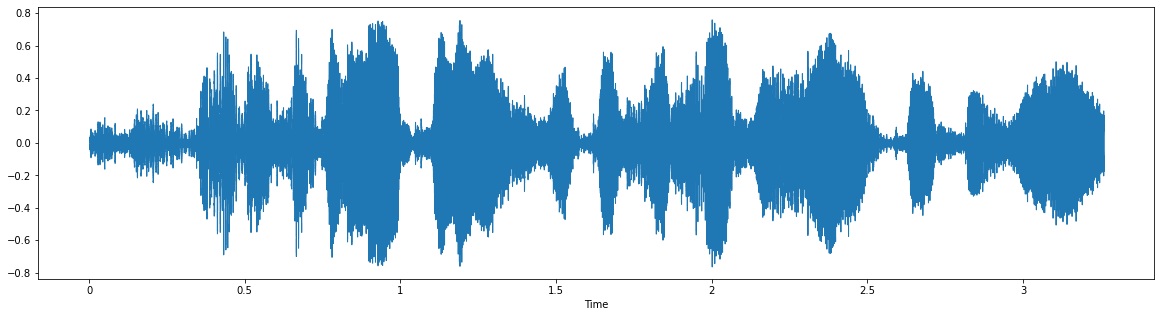

In [8]:
%matplotlib inline
eda = EDA()
eda.sound_plots(audio,rate,'waveshow')


### Spectrogram
 
A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform. Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time.

A spectrogram is usually depicted as a heat map, i.e., as an image with the intensity shown by varying the color or brightness.

We can display a spectrogram using. librosa.display.specshow.

In [9]:
spe_samples,frequency=eda.spectrogram(audio)

In [10]:
frequency

array([0.       , 0.0078125, 0.015625 , 0.0234375, 0.03125  , 0.0390625,
       0.046875 , 0.0546875, 0.0625   , 0.0703125, 0.078125 , 0.0859375,
       0.09375  , 0.1015625, 0.109375 , 0.1171875, 0.125    , 0.1328125,
       0.140625 , 0.1484375, 0.15625  , 0.1640625, 0.171875 , 0.1796875,
       0.1875   , 0.1953125, 0.203125 , 0.2109375, 0.21875  , 0.2265625,
       0.234375 , 0.2421875, 0.25     , 0.2578125, 0.265625 , 0.2734375,
       0.28125  , 0.2890625, 0.296875 , 0.3046875, 0.3125   , 0.3203125,
       0.328125 , 0.3359375, 0.34375  , 0.3515625, 0.359375 , 0.3671875,
       0.375    , 0.3828125, 0.390625 , 0.3984375, 0.40625  , 0.4140625,
       0.421875 , 0.4296875, 0.4375   , 0.4453125, 0.453125 , 0.4609375,
       0.46875  , 0.4765625, 0.484375 , 0.4921875, 0.5      , 0.5078125,
       0.515625 , 0.5234375, 0.53125  , 0.5390625, 0.546875 , 0.5546875,
       0.5625   , 0.5703125, 0.578125 , 0.5859375, 0.59375  , 0.6015625,
       0.609375 , 0.6171875, 0.625    , 0.6328125, 

In [11]:
spe_samples

array([[1.13884106e-02, 3.21214096e-02, 6.91762784e-03, ...,
        6.41432753e-04, 7.03752058e-02, 1.17736311e-02],
       [7.77638756e-02, 5.22206538e-02, 8.25680031e-02, ...,
        4.49584222e-01, 5.37294785e-01, 5.21421491e-01],
       [6.56095460e-02, 3.48477836e-02, 5.99835893e-02, ...,
        8.25518615e-01, 6.96491904e-01, 8.35559602e-01],
       ...,
       [4.56833798e-16, 2.07337527e-17, 2.06271118e-16, ...,
        2.77101034e-15, 1.40139931e-15, 3.30926759e-19],
       [1.56617902e-16, 5.05070645e-18, 1.35031941e-16, ...,
        4.60408946e-15, 3.23087256e-17, 1.88152924e-16],
       [2.95560527e-16, 3.62370679e-19, 9.09982531e-18, ...,
        7.73019767e-17, 4.24826768e-16, 3.74392207e-17]])

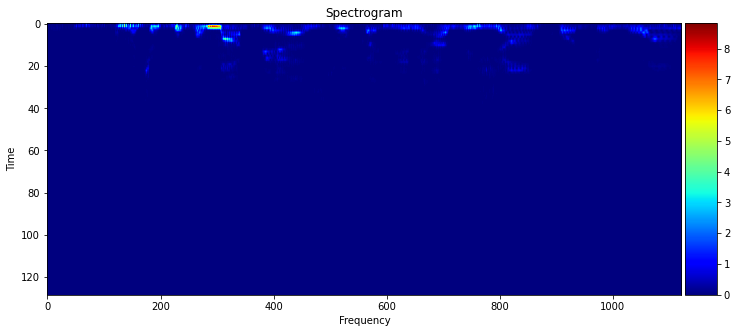

In [12]:
eda.plot_spectrogram_feature(spe_samples)

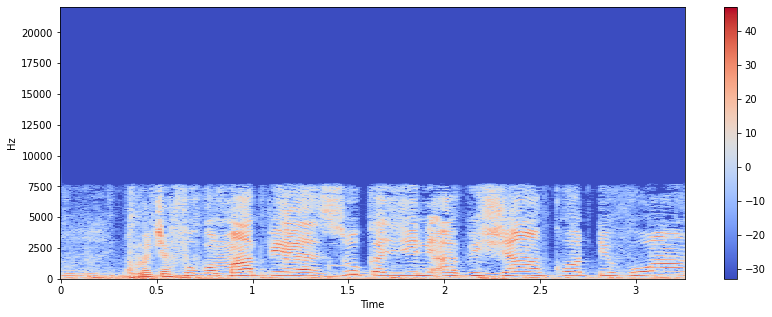

In [13]:
eda.sound_plots(audio,rate,'specshow')

The vertical axis shows frequencies (from 0 to 8kHz), and the horizontal axis shows the time of the clip. 

.stft() converts data into short term Fourier transform. STFT converts signals such that we can know the amplitude of the given frequency at a given time. Using STFT we can determine the amplitude of various frequencies playing at a given time of an audio signal.
.specshow is used to display a spectrogram.
The vertical axis shows frequencies (from 0 to 10kHz), and the horizontal axis shows the time of the clip. 


# Data Augumentation

###Time Shifting
Here we shift the wave by sample_rate/10 factor. This will move the wave to the right by given factor along time axis.
For achieving this I have used numpy’s roll function to generate time shifting.


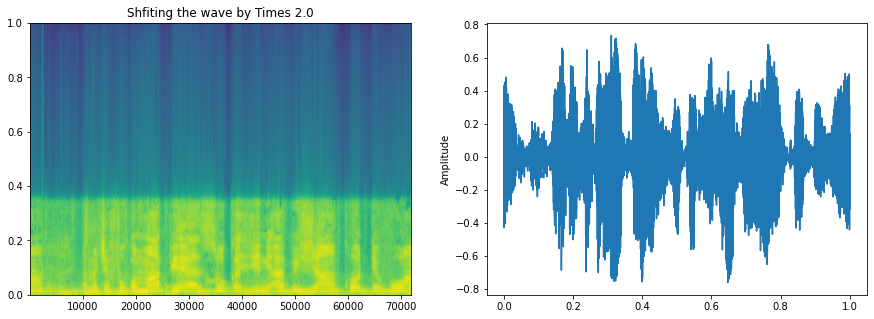

In [14]:
wav_roll = np.roll(audio,int(rate/9))
eda.plot_spec(data=wav_roll,sr=20)
ipd.Audio(wav_roll,rate=rate)

Other Data Augumentation Methods are
1. Pitch Shifting
2. Time Streching 

###Feature extraction from Audio signal
 
Every audio signal consists of many features. However, we must extract the characteristics that are relevant to the problem we are trying to solve. The process of extracting features to use them for analysis is called feature extraction. 


**Mel-Frequency Cepstral Coefficients(MFCCs)**

The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. It models the characteristics of the human voice.



In [15]:
mfcc_features = eda.features(audio,rate,'mfcc')

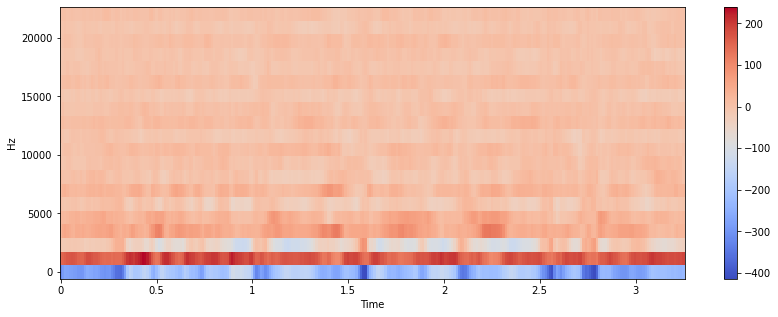

In [16]:
eda.sound_plots(audio,rate,'specshow',features=mfcc_features)

# Transcription preprocessing 

In [7]:
swahili_train_labels = cleaning_audios.get_labels('swahili','train')
swahili_test_labels = cleaning_audios.get_labels('swahili','test')
amharic_train_labels = cleaning_audios.get_labels('amharic','train')
amharic_test_labels = cleaning_audios.get_labels('amharic','test')

In [8]:
swahili_text_data, swahili_label_data = cleaning_audios.read_data('../data/swahili_train_text.txt', '../data/swahili_test_text.txt',
                                                  swahili_train_labels, swahili_test_labels)
amharic_text_data, amharic_label_data = cleaning_audios.read_data('../data/amharic_train_text.txt', '../data/amharic_test_text.txt',
                                                  amharic_train_labels, amharic_test_labels)

2022-05-31 16:39:05,349:logger:successfully read file
2022-05-31 16:39:05,409:logger:successfully read file
2022-05-31 16:39:07,114:logger:Successfully read the data
2022-05-31 16:39:07,136:logger:successfully read file
2022-05-31 16:39:07,208:logger:successfully read file
2022-05-31 16:39:08,820:logger:Successfully read the data


In [9]:
swahili_data = pd.DataFrame({'key': swahili_label_data, 'text': swahili_text_data})
amharic_data = pd.DataFrame({'key': amharic_label_data, 'text': amharic_text_data})

In [ ]:
# swahili_recordings = cleaning_audios.load_audios('swahili',files=swahili_data.key.to_list())
amharic_recordings = cleaning_audios.load_audios('amharic',files=amharic_data.key.to_list())

2022-05-31 16:17:56,268:logger:successfully loaded tr_2426_tr25027.wav
2022-05-31 16:17:56,956:logger:successfully loaded tr_7707_tr78008.wav
2022-05-31 16:17:57,226:logger:successfully loaded tr_5611_tr57012.wav
2022-05-31 16:17:57,673:logger:successfully loaded tr_7251_tr73052.wav
2022-05-31 16:17:58,396:logger:successfully loaded tr_953_tr10054.wav
2022-05-31 16:17:59,191:logger:successfully loaded tr_6344_tr64045.wav
2022-05-31 16:17:59,641:logger:successfully loaded tr_5846_tr59047.wav
2022-05-31 16:18:00,216:logger:successfully loaded tr_5295_tr53096.wav
2022-05-31 16:18:00,522:logger:successfully loaded tr_8302_tr83063.wav
2022-05-31 16:18:00,843:logger:successfully loaded tr_5882_tr59083.wav
2022-05-31 16:18:01,391:logger:successfully loaded tr_2502_tr26003.wav
2022-05-31 16:18:01,758:logger:successfully loaded tr_811_tr09011.wav
2022-05-31 16:18:02,173:logger:successfully loaded tr_4331_tr44032.wav
2022-05-31 16:18:02,546:logger:successfully loaded tr_9091_tr90012.wav
2022-05-

2022-05-31 16:18:53,760:logger:successfully loaded tr_10123_tr098085.wav
2022-05-31 16:18:54,542:logger:successfully loaded tr_5463_tr55064.wav
2022-05-31 16:18:55,347:logger:successfully loaded tr_1237_tr13038.wav
2022-05-31 16:18:56,138:logger:successfully loaded tr_769_tr08069.wav
2022-05-31 16:18:56,581:logger:successfully loaded tr_4909_tr50010.wav
2022-05-31 16:18:56,866:logger:successfully loaded tr_2945_tr30046.wav
2022-05-31 16:18:57,114:logger:successfully loaded tr_9783_tr095105.wav
2022-05-31 16:18:57,531:logger:successfully loaded tr_4526_tr46027.wav
2022-05-31 16:18:58,382:logger:successfully loaded tr_6027_tr61028.wav
2022-05-31 16:18:58,565:logger:successfully loaded tr_4848_tr49049.wav
2022-05-31 16:18:58,966:logger:successfully loaded tr_3748_tr38049.wav
2022-05-31 16:18:59,362:logger:successfully loaded tr_8045_tr81046.wav
2022-05-31 16:18:59,748:logger:successfully loaded tr_2683_tr27084.wav
2022-05-31 16:19:00,223:logger:successfully loaded tr_4406_tr45007.wav
2022

2022-05-31 16:19:52,184:logger:successfully loaded tr_6552_tr66053.wav
2022-05-31 16:19:52,681:logger:successfully loaded tr_2811_tr29012.wav
2022-05-31 16:19:53,728:logger:successfully loaded tr_7461_tr75062.wav
2022-05-31 16:19:54,766:logger:successfully loaded tr_1004_tr11005.wav
2022-05-31 16:19:55,379:logger:successfully loaded tr_5723_tr58024.wav
2022-05-31 16:19:55,961:logger:successfully loaded tr_481_tr05081.wav
2022-05-31 16:19:56,311:logger:successfully loaded tr_6805_tr69006.wav
2022-05-31 16:19:56,468:logger:successfully loaded tr_5730_tr58031.wav
2022-05-31 16:19:57,239:logger:successfully loaded tr_357_tr04057.wav
2022-05-31 16:19:58,150:logger:successfully loaded tr_7409_tr75010.wav
2022-05-31 16:19:58,566:logger:successfully loaded tr_5316_tr54017.wav
2022-05-31 16:19:58,897:logger:successfully loaded tr_10136_tr098098.wav
2022-05-31 16:19:59,263:logger:successfully loaded tr_5892_tr59093.wav
2022-05-31 16:20:00,188:logger:successfully loaded tr_1942_tr20043.wav
2022-0

2022-05-31 16:21:00,039:logger:successfully loaded tr_5640_tr57041.wav
2022-05-31 16:21:00,737:logger:successfully loaded tr_8855_tr88016.wav
2022-05-31 16:21:01,631:logger:successfully loaded tr_6873_tr69074.wav
2022-05-31 16:21:02,202:logger:successfully loaded tr_1667_tr17068.wav
2022-05-31 16:21:02,649:logger:successfully loaded tr_8189_tr82070.wav
2022-05-31 16:21:02,922:logger:successfully loaded tr_5946_tr60047.wav
2022-05-31 16:21:03,295:logger:successfully loaded tr_5614_tr57015.wav
2022-05-31 16:21:03,800:logger:successfully loaded tr_9743_tr095065.wav
2022-05-31 16:21:04,511:logger:successfully loaded tr_1955_tr20056.wav
2022-05-31 16:21:04,779:logger:successfully loaded tr_7979_tr80080.wav
2022-05-31 16:21:05,026:logger:successfully loaded tr_9654_tr094096.wav
2022-05-31 16:21:05,540:logger:successfully loaded tr_8881_tr88042.wav
2022-05-31 16:21:05,748:logger:successfully loaded tr_10083_tr098045.wav
2022-05-31 16:21:06,046:logger:successfully loaded tr_1139_tr12040.wav
20

In [ ]:
duration_of_recordings

In [ ]:
data["duration"] = duration_of_recordings

In [ ]:
y = [x in swahili_test_labels for x in swahili_data.key]
swahili_data["category"] = ["Test" if i else "Train" for i in y]
y = [x in amharic_test_labels for x in amharic_data.key]
amharic_data["category"] = ["Test" if i else "Train" for i in y]

In [ ]:
words_in_data = pd.DataFrame(' '.join(data['text']).split())
words_in_data.columns = ['word']
words_data = words_in_data.groupby(['word']).agg({'word': 'count'})
words_data.columns = ['counts']
words_data.reset_index(inplace=True)
words_data = words_data.sort_values("counts", ascending=False)
words_data.head(10)

In [ ]:
words_data.loc[words_data['counts'] < 1000, 'word'] = 'Others'
fig = px.pie(words_data, values='counts', names='word', title='Distribution of Words', width=800, height=500)
Image(pio.to_image(fig, format='png', width=1200))

# Converting Channels

In [16]:
cleaning_audios.convert_channels("../data/amharic_train_wav/tr_10000_tr097082.wav","../data/amharic_train_wav/tr_10000_tr097082_stereod.wav")

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=145408, comptype='NONE', compname='not compressed')
